In [6]:
import numpy as np
from numpy import genfromtxt
from scipy.interpolate import interp1d
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import row, column
from bokeh.io import push_notebook
from bokeh.models import Range1d, Label, Span
output_notebook()
import ipywidgets as widgets
from ipywidgets import FloatText, VBox, HBox, IntProgress

Loading BokehJS ...

Graph below is from Fundamentals of Fiber Lasers and Fiber Amplifiers, Valerii (Vartan) Ter-Mikirtychev, Springer, 2014

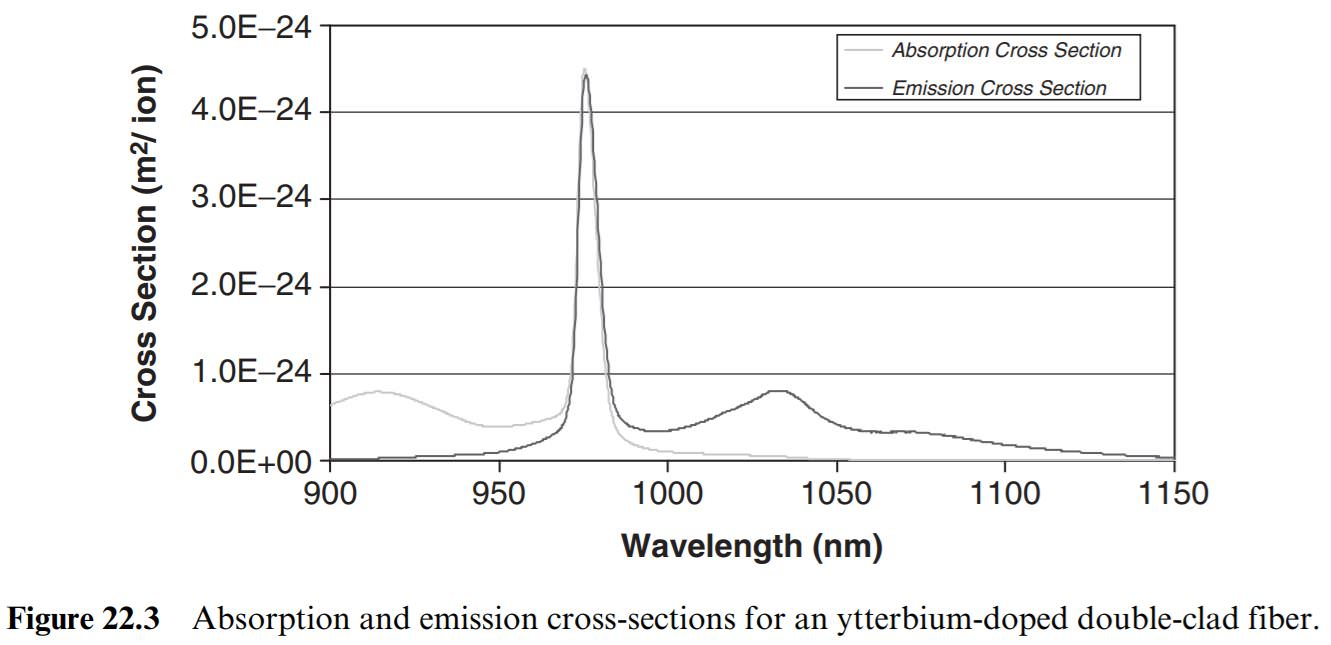

In [7]:
from IPython.core.display import Image 
Image(url='https://i.imgur.com/biIFUfc.jpg',embed=True,width=600)

Materials Parameters for Yb-Doped Fiber

In [8]:
sigmaa976 = 4.4e-20 # Absorption cross-section for a Wavelenth of 976 nm in square cm
sigmae1064 = 0.3e-20 # Emission cross-section for a Wavelenth of 1064 nm in square cm
sigmaa1064 = 0.0 # Absorption cross-section for a wavelength of 1064 nm in square cm
tau = 0.84e-3 # Excited state lifetime in seconds

Paramenters Determined by Fiber Geometry

In [9]:
gammas = 0.82 # Confinement factor for signals in core

In [81]:
# Stage 1
coreD_widget=widgets.FloatText(value=10, disabled=False)
cladD_widget=widgets.FloatText(value=125, disabled=False)
fiber_loss_widget=widgets.FloatText(value=1.0, disabled=False)
display(HBox([VBox([widgets.Label('Core Diameter (micron)'),coreD_widget]),
              VBox([widgets.Label('Cladding Diameter (micron)'),cladD_widget]),
             VBox([widgets.Label('Fiber Loss (dB/km)'),fiber_loss_widget])]))

rshift_widget = widgets.FloatText(value=450, disabled=False)
raman_gain_widget=widgets.FloatText(value=4, disabled=False)
raman_width_widget=widgets.FloatText(value=200, disabled=False)
display(HBox([VBox([widgets.Label('Raman Shift (inverse cm)'), rshift_widget]),
              VBox([widgets.Label('Peak Raman Gain (10^-12 cm/W)'), raman_gain_widget]),
             VBox([widgets.Label('Raman Curve Width (inverse cm)'), raman_width_widget])]))

Yb_conc_widget=widgets.FloatText(value=1200, disabled=False)
Ybpump_power_widget=widgets.FloatText(value=9, disabled=False)
display(HBox([VBox([widgets.Label('Yb concentration (ppm)'), Yb_conc_widget]),
             VBox([widgets.Label('Yb Pump Power (W)'), Ybpump_power_widget])]))

fundamental_wavelength_widget=widgets.FloatText(value=1030, disabled=False)
sigmae_widget=widgets.FloatText(value=8, disabled=False)
display(HBox([VBox([widgets.Label('Wavelength of Fundamental (nm)'), fundamental_wavelength_widget]),
            VBox([widgets.Label('Emission Cross-section of Fundamental (10^-21 cm^2)'), sigmae_widget])]))

FWHM_widget=widgets.FloatText(value=25, disabled=False)
Ep_widget=widgets.FloatText(value=2500, disabled=False)
insertion_loss_widget=FloatText(value=0.0, disabled=False)
display(HBox([VBox([widgets.Label('Initial FWHM of Fundamental Pulse (psec)'), FWHM_widget]),
              VBox([widgets.Label('Initial Pulse Energy (pJ)'), Ep_widget]),
             VBox([widgets.Label('Amplifier Insertion Loss (dB)'), insertion_loss_widget])]))

seed_power_widget=widgets.FloatText(value=0, disabled=False)
seed_wavelength_widget=widgets.FloatText(value=1125, disabled=False)
rep_rate_widget=widgets.FloatText(value=1.0, disabled=False)
display(HBox([VBox([widgets.Label('Seed Power (mW)'), seed_power_widget]),
              VBox([widgets.Label('Seed Wavelength (nm)'), seed_wavelength_widget]),
             VBox([widgets.Label('Pulse Repetition Rate (MHz)'), rep_rate_widget])]))

Ldoped_widget=widgets.FloatText(value=1, disabled=False)
delta_Ld_widget=widgets.FloatText(value=1.0, disabled=False)
display(HBox([VBox([widgets.Label('Doped Fiber Length (m)'), Ldoped_widget]),
              VBox([widgets.Label('Numerical Step - Doped Fiber Section (cm)'), delta_Ld_widget])]))

Lundoped_widget=widgets.FloatText(value=0, disabled=False)
delta_Lund_widget=widgets.FloatText(value=1.0, disabled=False)
display(HBox([VBox([widgets.Label('Undoped Fiber Length (m)'), Lundoped_widget]),
              VBox([widgets.Label('Numerical Step - Undoped Fiber Section (cm)'), delta_Lund_widget])]))

In [82]:
# Stage 1
coreD = coreD_widget.value*1e-4 # Core diameter in cm
cladD = cladD_widget.value*1e-4 # Cladding diameter in cm
fiber_loss = fiber_loss_widget.value/4.34/1e5 # background loss in optical fiber in inverse cm
rshift = rshift_widget.value # Raman shift in inverse cm
raman_gain = raman_gain_widget.value*1e-12 # Peak Raman Gain in cm/W
raman_width = raman_width_widget.value
Yb_conc = Yb_conc_widget.value # Yb concentration ppm
Ybpump_power = Ybpump_power_widget.value # Yb pump power in W
fundamental_wavelength = fundamental_wavelength_widget.value # fundamental wavelength in nm
sigmae = sigmae_widget.value*1e-21 # emission cross-section at wavelength of fundamental
FWHM = FWHM_widget.value # FWHM of pulse in psec
insertion_loss = 10**(-insertion_loss_widget.value/10)
Ep = Ep_widget.value*1e-12*insertion_loss #pulse energy in Joules
stokesw1 = seed_wavelength_widget.value # Wavelength of 1st Stokes signal in nm
stokesw2 = 1e7/(-rshift_widget.value+1e7/stokesw1) # Wavelength of 2st Stokes signal in nm
seed_power = seed_power_widget.value/1000*insertion_loss # power in Watt
rep_rate = rep_rate_widget.value*1e6 # pulse repetition rate in Hz
Ldoped = Ldoped_widget.value # length of doped fiber in meters at beginning of fiber
Lundoped = Lundoped_widget.value # Length of undoped fiber in meters
delta_Ld = delta_Ld_widget.value # numerical distance increment in cm for doped fiber
delta_Lund = delta_Lund_widget.value # numerical distance increment in cm for undoped fiber

hnu_pump=1239.42/976*1.6022e-19
pump_loss0 = sigmaa976*Yb_conc*1e-6*6.02214e23*2.2/60*(coreD**2/cladD**2) # unsaturated pump loss in inverse cm
print('Unsaturated Yb Pump Loss = %4.2f (dB/m)' % (pump_loss0*100*4.34))
NYb = Yb_conc*1e-6*6.02214e23*2.2/60 # Yb concentration in inverse cubic cm
print('NYb = ', NYb)
print('Ybpump_power = ', Ybpump_power)
Nexc0 = Ybpump_power/(np.pi*cladD**2/4)*pump_loss0*tau/hnu_pump/(coreD**2/cladD**2) # Excited State Density - Unsat Pump Loss
Nexc = Nexc0/(1+Nexc0/NYb)
print('Excited State Density Nexc0 = %4.2e (#/cm^3)' % Nexc0)
print('Excited State Density Nexc = %4.2e (#/cm^3)' % Nexc)
pump_loss=pump_loss0*(1-Nexc/NYb)
print('Yb Pump Loss = %4.2f (dB/m)' % (pump_loss*100*4.34))
fundamental_gain_us=Nexc*sigmae1064 # unsaturated gain of the fundamental in inverse cm
print('Intital Unsaturated Gain for Fundamental = %4.2f (dB/m)' % (fundamental_gain_us*100*4.34))
Aeff = np.pi*(coreD/2)**2/(-np.log(1-gammas)/2) # Effective area for signals in core
raman_width_Hz = raman_width/(1e7/stokesw1)*(3e17/stokesw1) # Width of equivalent spontaneous Raman input in Hz 

t=np.linspace(-200,200,101)
I0=(Ep/Aeff)*(np.sqrt(4*np.log(2)/np.pi)/FWHM)*1e12
fundamental=I0*np.exp(-4*np.log(2)*(t/FWHM)**2)
hnu_signal1=1239.842/stokesw1*1.6022e-19
signal1=np.zeros(101)+seed_power/Aeff+hnu_signal1*raman_width_Hz/Aeff
hnu_signal2=1239.842/stokesw2*1.6022e-19
signal2=np.zeros(101)+hnu_signal2*raman_width_Hz/Aeff
hnu_fundamental=1239.842/fundamental_wavelength*1.6022e-19
Ps1_sat = hnu_fundamental*(np.pi*(coreD**2/4))/gammas/(sigmaa1064+sigmae1064)/tau
print('Ps1_sat = ',Ps1_sat)
P_ASE = hnu_pump*5.3e12
P_ones = np.ones(101)
P_ASE_line = P_ones*P_ASE
print('Initial ASE Power = ',P_ASE, 'Watt')
fundamental_gain=fundamental_gain_us/(1+(np.sum(fundamental*Aeff)*40e-12*rep_rate+P_ASE)/Ps1_sat)
print('Fundamental Gain = ', fundamental_gain)

pg=figure(plot_width=450, plot_height=400, y_axis_type="log")
pg.min_border_top = 10
pg.outline_line_width = 1
pg.outline_line_alpha = 1
pg.outline_line_color = "black"
pg.background_fill_color = "lightgrey"
pg.background_fill_alpha = 0.3

label1=Label(x=10, y=300, x_units='screen', y_units='screen', text='Average Power',
             text_font_size='10pt', text_color='darkblue')
label2=Label(x=10, y=250, x_units='screen', y_units='screen', text='Pulse Energy',
             text_font_size='10pt', text_color='darkblue')
label3=Label(x=5, y=200, x_units='screen', y_units='screen', text='ASE Power',
             text_font_size='10pt', text_color='darkblue')
pg.add_layout(label1)
pg.add_layout(label2)
pg.add_layout(label3)

pg.x_range = Range1d(-200,200)
pg.y_range = Range1d(8e-7,1e6)
cp=pg.line(t,fundamental*Aeff, legend=str(int(fundamental_wavelength))+" nm", color='blue', line_width=2)
c=pg.line(t, signal1*Aeff, legend="1st Stokes", color='green', line_width=2)
c2=pg.line(t, signal2*Aeff, legend="2nd Stokes", color='red', line_width=2)
c3=pg.line(t,P_ASE_line, legend='ASE', color='blue', line_width=2, line_dash='dashed')
pg.legend.location = "top_right"; pg.legend.background_fill_alpha = 0.7
pg.xaxis.axis_label = 'Time (psec)'; pg.xaxis.axis_label_text_font_size = "12pt"
pg.xaxis.major_label_text_font_size = "12pt"
pg.yaxis.axis_label = 'Signal (Watt)'; pg.yaxis.axis_label_text_font_size = "12pt"
pg.yaxis.major_label_text_font_size = "12pt"

pc=figure(plot_width=450, plot_height=400, y_axis_type="log")
pc.outline_line_width = 1
pc.outline_line_alpha = 1
pc.outline_line_color = "black"
pc.background_fill_color = "lightgrey"
pc.background_fill_alpha = 0.3

pc.x_range = Range1d(0,Lundoped+Ldoped)
pc.xaxis.axis_label = 'Distance Along Fiber (meter)'; pc.xaxis.axis_label_text_font_size = "12pt"
pc.xaxis.major_label_text_font_size = "12pt"
pc.yaxis.axis_label = 'Pulse Energy (Joule)'; pc.yaxis.axis_label_text_font_size = "12pt"
pc.yaxis.major_label_text_font_size = "12pt"

doped_fiber_L = Span(location=Ldoped, dimension='height', line_color='black',
                              line_dash='dashed', line_width=1)
pc.add_layout(doped_fiber_L)

nh=show(row(pg,pc),notebook_handle='true')

import time
t0 = time.time()

dopedn = int(Ldoped*1e2/delta_Ld)
undopedn = int(Lundoped*1e2/delta_Lund)
P = IntProgress(min=0, max=dopedn+undopedn-1, description='Progress', bar_style='success'); display(P)
zd=np.linspace(0,Ldoped,dopedn+1)
zund=np.linspace(Ldoped+delta_Lund*1e-2,Ldoped+Lundoped,undopedn)
z=np.concatenate([zd,zund])
Epz=np.zeros(dopedn+undopedn+1)
Epz[0]=Ep
Es1pz=np.zeros(dopedn+undopedn+1)
Es2z=np.zeros(dopedn+undopedn+1)
for i in range(dopedn):
    delta_signal1=fundamental*signal1*raman_gain*delta_Ld
    signal1=signal1+delta_signal1
    fundamental=fundamental*(1+fundamental_gain*delta_Ld)
    fundamental=fundamental-delta_signal1*stokesw1/fundamental_wavelength
    P_ASE = P_ASE*(1+fundamental_gain*delta_Ld)
    delta_signal2=signal1*signal2*raman_gain*delta_Ld
    signal2=signal2+delta_signal2
    signal1=signal1-delta_signal2*stokesw1/stokesw2
    Ybpump_power = Ybpump_power*(1-pump_loss*delta_Ld)
    fundamental = fundamental*(1-fiber_loss*delta_Ld)
    signal1 = signal1*(1-fiber_loss*delta_Ld)
    signal2 = signal2*(1-fiber_loss*delta_Ld)
    Nexc0 = Nexc0*(1-pump_loss*delta_Ld)
    Nexc = Nexc0/(1+Nexc0/NYb)
    pump_loss=pump_loss0*(1-Nexc/NYb)   
    fundamental_gain_us=Nexc*sigmae1064
    fundamental_gain=fundamental_gain_us/(1+(np.sum(fundamental*Aeff)*40e-12*rep_rate+P_ASE)/Ps1_sat)
    c.data_source.data['y']=signal1*Aeff
    cp.data_source.data['y']=fundamental*Aeff
    c2.data_source.data['y']=signal2*Aeff
    c3.data_source.data['y']=P_ones*P_ASE
    
    Es1pz[i+1]=np.sum((signal1-seed_power/Aeff)*Aeff)*4e-12
    Es2z[i+1]=np.sum((signal2)*Aeff)*4e-12
    Epz[i+1]=np.sum(fundamental*Aeff)*4e-12
    P.value=i
    if i % 20 == 0 or i == dopedn+undopedn-1:
        push_notebook(handle=nh)
        time.sleep(.200)
for i in range(dopedn,dopedn+undopedn):
    delta_signal1=fundamental*signal1*raman_gain*delta_Lund
    signal1=signal1+delta_signal1
    fundamental=fundamental-delta_signal1*stokesw1/fundamental_wavelength
    delta_signal2=signal1*signal2*raman_gain*delta_Lund
    signal2=signal2+delta_signal2
    signal1=signal1-delta_signal2*stokesw1/stokesw2
    Ybpump_power = Ybpump_power*(1-pump_loss*delta_Lund)
    fundamental = fundamental*(1-fiber_loss*delta_Lund)
    signal1 = signal1*(1-fiber_loss*delta_Lund)
    signal2 = signal2*(1-fiber_loss*delta_Lund)
    c.data_source.data['y']=signal1*Aeff
    cp.data_source.data['y']=fundamental*Aeff
    c2.data_source.data['y']=signal2*Aeff
    
    Es1pz[i+1]=np.sum((signal1-seed_power/Aeff)*Aeff)*4e-12
    Es2z[i+1]=np.sum((signal2-seed_power/Aeff)*Aeff)*4e-12
    Epz[i+1]=np.sum(fundamental*Aeff)*4e-12
    P.value=i
    if i % 20 == 0 or i == dopedn+undopedn-1:
        push_notebook(handle=nh)
        time.sleep(.200)

pc.line(z,Epz,color='blue',line_width=2,legend=str(int(fundamental_wavelength))+' nm')
pc.line(z,Es1pz,color='green',line_width=2,legend="1st Stokes")
pc.line(z,Es2z,color='red',line_width=2,legend="2nd Stokes")
pc.legend.location = "center_right"
push_notebook(handle=nh)

max_ave_fpower=np.max(Epz)*rep_rate
label1a=Label(x=10, y=280, x_units='screen', y_units='screen', text='= {} W'.format("%2.1e" % max_ave_fpower),
             text_font_size='10pt', text_color='darkblue')
pg.add_layout(label1a)
label2a=Label(x=10, y=230, x_units='screen', y_units='screen', text='= {} J'.format("%1.1e" % np.max(Epz)),
             text_font_size='10pt', text_color='darkblue')
pg.add_layout(label2a)
label3a=Label(x=10, y=180, x_units='screen', y_units='screen', text='= {} W'.format("%1.1e" % P_ASE),
             text_font_size='10pt', text_color='darkblue')
pg.add_layout(label3a)            
push_notebook(handle=nh)

np.save('fundamental_1.npy', fundamental)
np.save('signal1_1.npy', signal1)
np.save('signal2_1.npy', signal2)
np.save('Aeff_1.npy', Aeff)
np.save('P_ASE_1.npy', P_ASE)

t1=time.time()
print('elapsed time=',t1-t0)

Unsaturated Yb Pump Loss = 3.24 (dB/m)
NYb =  2.6497415999999996e+19
Ybpump_power =  9.0
Excited State Density Nexc0 = 3.53e+20 (#/cm^3)
Excited State Density Nexc = 2.46e+19 (#/cm^3)
Yb Pump Loss = 0.23 (dB/m)
Intital Unsaturated Gain for Fundamental = 32.09 (dB/m)
Ps1_sat =  0.07330293013270946
Initial ASE Power =  1.0783538152868854e-06 Watt
Fundamental Gain =  0.055136770604827474


IntProgress(value=0, bar_style='success', description='Progress', max=99)

elapsed time= 8.391194105148315


In [83]:
# Stage 2
coreD_widget2=widgets.FloatText(value=20, disabled=False)
cladD_widget2=widgets.FloatText(value=130, disabled=False)
fiber_loss_widget2=widgets.FloatText(value=1.0, disabled=False)
display(HBox([VBox([widgets.Label('Core Diameter (micron)'),coreD_widget2]),
              VBox([widgets.Label('Cladding Diameter (micron)'),cladD_widget2]),
             VBox([widgets.Label('Fiber Loss (dB/km)'),fiber_loss_widget2])]))

rshift_widget2 = widgets.FloatText(value=450, disabled=False)
raman_gain_widget2=widgets.FloatText(value=4, disabled=False)
raman_width_widget2=widgets.FloatText(value=200, disabled=False)
display(HBox([VBox([widgets.Label('Raman Shift (inverse cm)'), rshift_widget2]),
              VBox([widgets.Label('Peak Raman Gain (10^-12 cm/W)'), raman_gain_widget2]),
             VBox([widgets.Label('Raman Curve Width (inverse cm)'), raman_width_widget2])]))

Yb_conc_widget2=widgets.FloatText(value=1200, disabled=False)
Ybpump_power_widget2=widgets.FloatText(value=9, disabled=False)
display(HBox([VBox([widgets.Label('Yb concentration (ppm)'), Yb_conc_widget2]),
             VBox([widgets.Label('Yb Pump Power (W)'), Ybpump_power_widget2])]))

insertion_loss_widget2=widgets.FloatText(value=0.0, disabled=False)
display(HBox([VBox([widgets.Label('Amplifier Insertion Loss (dB)'), insertion_loss_widget2])]))

seed_power_widget2=widgets.FloatText(value=0, disabled=False)
seed_wavelength_widget2=widgets.FloatText(value=1125, disabled=False)
display(HBox([VBox([widgets.Label('Seed Power (mW)'), seed_power_widget2]),
              VBox([widgets.Label('Seed Wavelength (nm)'), seed_wavelength_widget2])]))

fiber_length_widget2=widgets.FloatText(value=2, disabled=False)
Ldoped_widget2=widgets.FloatText(value=2, disabled=False)
delta_L_widget2=widgets.FloatText(value=1.0, disabled=False)
display(HBox([VBox([widgets.Label('Total Fiber Length (m)'), fiber_length_widget2]),
              VBox([widgets.Label('Doped Fiber Length (m)'), Ldoped_widget2]),
              VBox([widgets.Label('Numerical Step Size (cm)'), delta_L_widget2])]))

fundamental_1 = np.load('fundamental_1.npy')
signal1_1 = np.load('signal1_1.npy')
signal2_1 = np.load('signal2_1.npy')
Aeff_1 = np.load('Aeff_1.npy')
P_ASE_1 = np.load('P_ASE_1.npy')

In [84]:
# Stage 2
coreD = coreD_widget2.value*1e-4 # Core diameter in cm
cladD = cladD_widget2.value*1e-4 # Cladding diameter in cm
fiber_loss = fiber_loss_widget2.value/4.34/1e5 # background loss in optical fiber in inverse cm
rshift = rshift_widget2.value # Raman shift in inverse cm
raman_gain = raman_gain_widget2.value*1e-12 # Peak Raman Gain in cm/W
raman_width = raman_width_widget2.value
Yb_conc = Yb_conc_widget2.value # Yb concentration ppm
Ybpump_power = Ybpump_power_widget2.value # Yb pump power in W
insertion_loss = 10**(-insertion_loss_widget2.value/10)
stokesw1 = seed_wavelength_widget2.value # Wavelength of 1st Stokes signal in nm
stokesw2 = 1e7/(-rshift_widget2.value+1e7/stokesw1) # Wavelength of 2st Stokes signal in nm
seed_power = seed_power_widget2.value/1000*insertion_loss # power in Watt
fiber_length = fiber_length_widget2.value # total fiber Length in meters
Ldoped = Ldoped_widget2.value # length of doped fiber in meters at beginning of fiber
delta_L = delta_L_widget2.value # numerical distance increment in cm

pump_loss0 = sigmaa976*Yb_conc*1e-6*6.02214e23*2.2/60*(coreD**2/cladD**2) # unsaturated pump loss in inverse cm
print('Unsaturated Yb Pump Loss = %4.2f (dB/m)' % (pump_loss0*100*4.34))
NYb = Yb_conc*1e-6*6.02214e23*2.2/60 # Yb concentration in inverse cubic cm
print('NYb = ', NYb)
Nexc0 = Ybpump_power/(np.pi*cladD**2/4)*pump_loss0*tau/hnu_pump/(coreD**2/cladD**2) # Excited State Density - Unsat Pump Loss
Nexc = Nexc0/(1+Nexc0/NYb)
print('Excited State Density Nexc0 = %4.2e (#/cm^3)' % Nexc0)
print('Excited State Density Nexc = %4.2e (#/cm^3)' % Nexc)
pump_loss=pump_loss0*(1-Nexc/NYb)
print('Yb Pump Loss = %4.2f (dB/m)' % (pump_loss*100*4.34))
fundamental_gain_us=Nexc*sigmae1064 # unsaturated gain of the fundamental in inverse cm
print('Intital Unsaturated Gain for Fundamental = %4.2f (dB/m)' % (fundamental_gain_us*100*4.34))
Aeff = np.pi*(coreD/2)**2/(-np.log(1-gammas)/2) # Effective area for signals in core
raman_width_Hz = raman_width/(1e7/stokesw1)*(3e17/stokesw1) # Width of equivalent spontaneous Raman input in Hz 

t=np.linspace(-200,200,101)
fundamental=fundamental_1*Aeff_1/Aeff*insertion_loss
hnu_signal1=1239.842/stokesw1*1.6022e-19
signal1=signal1_1*Aeff_1/Aeff*insertion_loss+seed_power/Aeff+hnu_signal1*raman_width_Hz/Aeff
seed_power=seed_power*insertion_loss
hnu_signal2=1239.842/stokesw2*1.6022e-19
signal2=np.zeros(101)+hnu_signal2*raman_width_Hz/Aeff
hnu_fundamental=1239.842/fundamental_wavelength*1.6022e-19
Ps1_sat = hnu_fundamental*(np.pi*(coreD**2/4))/gammas/(sigmaa1064+sigmae1064)/tau
print('Ps1_sat = ',Ps1_sat)
P_ASE = P_ASE_1
P_ones = np.ones(101)
P_ASE_line = P_ones*P_ASE
print('Initial ASE Power = ',P_ASE, 'Watt')
fundamental_gain=fundamental_gain_us/(1+(np.sum(fundamental*Aeff)*40e-12*rep_rate+P_ASE)/Ps1_sat)
print('Fundamental Gain = ', fundamental_gain)

pg=figure(plot_width=450, plot_height=400, y_axis_type="log")
pg.min_border_top = 10
pg.outline_line_width = 1
pg.outline_line_alpha = 1
pg.outline_line_color = "black"
pg.background_fill_color = "lightgrey"
pg.background_fill_alpha = 0.3

label1=Label(x=10, y=300, x_units='screen', y_units='screen', text='Average Power',
             text_font_size='10pt', text_color='darkblue')
label2=Label(x=10, y=250, x_units='screen', y_units='screen', text='Pulse Energy',
             text_font_size='10pt', text_color='darkblue')
label3=Label(x=5, y=200, x_units='screen', y_units='screen', text='ASE Power',
             text_font_size='10pt', text_color='darkblue')
pg.add_layout(label1)
pg.add_layout(label2)
pg.add_layout(label3)

pg.x_range = Range1d(-200,200)
pg.y_range = Range1d(1e-4,1e6)
cp=pg.line(t,fundamental*Aeff, legend=str(int(fundamental_wavelength))+" nm", color='blue', line_width=2)
c=pg.line(t, signal1*Aeff, legend="1st Stokes", color='green', line_width=2)
c2=pg.line(t, signal2*Aeff, legend="2nd Stokes", color='red', line_width=2)
c3=pg.line(t,P_ASE_line, legend='ASE', color='blue', line_width=2, line_dash='dashed')
pg.legend.location = "top_right"; pg.legend.background_fill_alpha = 0.7
pg.xaxis.axis_label = 'Time (psec)'; pg.xaxis.axis_label_text_font_size = "12pt"
pg.xaxis.major_label_text_font_size = "12pt"
pg.yaxis.axis_label = 'Signal (Watt)'; pg.yaxis.axis_label_text_font_size = "12pt"
pg.yaxis.major_label_text_font_size = "12pt"

pc=figure(plot_width=450, plot_height=400, y_axis_type="log")
pc.outline_line_width = 1
pc.outline_line_alpha = 1
pc.outline_line_color = "black"
pc.background_fill_color = "lightgrey"
pc.background_fill_alpha = 0.3

pc.x_range = Range1d(0,fiber_length)
pc.xaxis.axis_label = 'Distance Along Fiber (meter)'; pc.xaxis.axis_label_text_font_size = "12pt"
pc.xaxis.major_label_text_font_size = "12pt"
pc.yaxis.axis_label = 'Pulse Energy (Joule)'; pc.yaxis.axis_label_text_font_size = "12pt"
pc.yaxis.major_label_text_font_size = "12pt"

doped_fiber_L = Span(location=Ldoped, dimension='height', line_color='black',
                              line_dash='dashed', line_width=1)
pc.add_layout(doped_fiber_L)

nh=show(row(pg,pc),notebook_handle='true')

import time
t0 = time.time()

rangen = int(fiber_length*1e2/delta_L)
dopedn = int(Ldoped*1e2/delta_L)
P = IntProgress(min=0, max=rangen, description='Progress', bar_style='success'); display(P)
z=np.linspace(0,fiber_length,rangen+1)
Epz=np.zeros(rangen+1)
Es1pz=np.zeros(rangen+1)
Es2z=np.zeros(rangen+1)
Epz[0]=np.sum(fundamental*Aeff)*40e-12
Es1pz[0]=np.sum((signal1-signal1[0])*Aeff)*40e-12
Es2z[0]=np.sum(signal2*Aeff)*40e-12

for i in range(rangen):
    if i >= dopedn:
        fundamental_gain=0
    delta_signal1=fundamental*signal1*raman_gain*delta_L
    signal1=signal1+delta_signal1
    fundamental=fundamental-delta_signal1*stokesw1/fundamental_wavelength
    fundamental=fundamental*(1+fundamental_gain*delta_L)
    P_ASE = P_ASE*(1+fundamental_gain*delta_Ld)

    delta_signal2=signal1*signal2*raman_gain*delta_L
    signal2=signal2+delta_signal2
    signal1=signal1-delta_signal2*stokesw1/stokesw2
    Ybpump_power = Ybpump_power*(1-pump_loss*delta_L)
    fundamental = fundamental*(1-fiber_loss*delta_L)
    signal1 = signal1*(1-fiber_loss*delta_L)
    signal2 = signal2*(1-fiber_loss*delta_L)
    Nexc0 = Nexc0*(1-pump_loss*delta_L)
    Nexc = Nexc0/(1+Nexc0/NYb)
    pump_loss=pump_loss0*(1-Nexc/NYb)   
    fundamental_gain_us=Nexc*sigmae1064
    fundamental_gain=fundamental_gain_us/(1+(np.sum(fundamental*Aeff)*40e-12*rep_rate+P_ASE)/Ps1_sat)
    c.data_source.data['y']=signal1*Aeff
    cp.data_source.data['y']=fundamental*Aeff
    c2.data_source.data['y']=signal2*Aeff
    c3.data_source.data['y']=P_ones*P_ASE
    
    Es1pz[i+1]=np.sum(signal1*Aeff-seed_power)*4e-12
    Es2z[i+1]=np.sum(signal2*Aeff)*4e-12
    Epz[i+1]=np.sum(fundamental*Aeff)*4e-12
    P.value=i
    if i % 20 == 0 or i == rangen-1:
        push_notebook(handle=nh)
        time.sleep(.200)

pc.line(z,Epz,color='blue',line_width=2,legend=str(int(fundamental_wavelength))+' nm')
pc.line(z,Es1pz,color='green',line_width=2,legend="1st Stokes")
pc.line(z,Es2z,color='red',line_width=2,legend="2nd Stokes")
pc.legend.location = "center_right"
push_notebook(handle=nh)

max_ave_fpower=np.max(Epz)*rep_rate
label1a=Label(x=10, y=280, x_units='screen', y_units='screen', text='= {} W'.format("%2.1e" % max_ave_fpower),
             text_font_size='10pt', text_color='darkblue')
pg.add_layout(label1a)
label2a=Label(x=10, y=230, x_units='screen', y_units='screen', text='= {} J'.format("%1.1e" % np.max(Epz)),
             text_font_size='10pt', text_color='darkblue')
pg.add_layout(label2a)
label3a=Label(x=10, y=180, x_units='screen', y_units='screen', text='= {} W'.format("%1.1e" % P_ASE),
             text_font_size='10pt', text_color='darkblue')
pg.add_layout(label3a)
push_notebook(handle=nh)

np.save('fundamental_2.npy', fundamental)
np.save('signal1_2.npy', signal1)
np.save('signal2_2.npy', signal2)
np.save('Aeff_2.npy', Aeff)
np.save('P_ASE_2.npy', P_ASE)

t1=time.time()
print('elapsed time=',t1-t0)

Unsaturated Yb Pump Loss = 11.98 (dB/m)
NYb =  2.6497415999999996e+19
Excited State Density Nexc0 = 3.26e+20 (#/cm^3)
Excited State Density Nexc = 2.45e+19 (#/cm^3)
Yb Pump Loss = 0.90 (dB/m)
Intital Unsaturated Gain for Fundamental = 31.91 (dB/m)
Ps1_sat =  0.2932117205308378
Initial ASE Power =  1.5790452702614165e-05 Watt
Fundamental Gain =  0.03270199470495407


IntProgress(value=0, bar_style='success', description='Progress', max=200)

elapsed time= 9.973960399627686


In [85]:
# Stage 3
coreD_widget3=widgets.FloatText(value=30, disabled=False)
cladD_widget3=widgets.FloatText(value=250, disabled=False)
fiber_loss_widget3=widgets.FloatText(value=2.0, disabled=False)
display(HBox([VBox([widgets.Label('Core Diameter (micron)'),coreD_widget3]),
              VBox([widgets.Label('Cladding Diameter (micron)'),cladD_widget3]),
             VBox([widgets.Label('Fiber Loss (dB/km)'),fiber_loss_widget3])]))

rshift_widget3 = widgets.FloatText(value=450, disabled=False)
raman_gain_widget3=widgets.FloatText(value=4, disabled=False)
raman_width_widget3=widgets.FloatText(value=200, disabled=False)
display(HBox([VBox([widgets.Label('Raman Shift (inverse cm)'), rshift_widget3]),
              VBox([widgets.Label('Peak Raman Gain (10^-12 cm/W)'), raman_gain_widget3]),
             VBox([widgets.Label('Raman Curve Width (inverse cm)'), raman_width_widget3])]))

Yb_conc_widget3=widgets.FloatText(value=1200, disabled=False)
Ybpump_power_widget3=widgets.FloatText(value=70, disabled=False)
display(HBox([VBox([widgets.Label('Yb concentration (ppm)'), Yb_conc_widget3]),
             VBox([widgets.Label('Yb Pump Power (W)'), Ybpump_power_widget3])]))

insertion_loss_widget3=widgets.FloatText(value=1.0, disabled=False)
display(HBox([VBox([widgets.Label('Amplifier Insertion Loss (dB)'), insertion_loss_widget3])]))

seed_power_widget3=widgets.FloatText(value=0, disabled=False)
seed_wavelength_widget3=widgets.FloatText(value=1125, disabled=False)
display(HBox([VBox([widgets.Label('Seed Power (mW)'), seed_power_widget3]),
              VBox([widgets.Label('Seed Wavelength (nm)'), seed_wavelength_widget3])]))

fiber_length_widget3=widgets.FloatText(value=4, disabled=False)
Ldoped_widget3=widgets.FloatText(value=4, disabled=False)
delta_L_widget3=widgets.FloatText(value=1.0, disabled=False)
display(HBox([VBox([widgets.Label('Total Fiber Length (m)'), fiber_length_widget3]),
              VBox([widgets.Label('Doped Fiber Length (m)'), Ldoped_widget3]),
              VBox([widgets.Label('Numerical Step Size (cm)'), delta_L_widget3])]))

fundamental_2 = np.load('fundamental_2.npy')
signal1_2 = np.load('signal1_2.npy')
signal2_2 = np.load('signal2_2.npy')
Aeff_2 = np.load('Aeff_2.npy')
P_ASE_2 = np.load('P_ASE_2.npy')

In [88]:
# Stage 3
coreD = coreD_widget3.value*1e-4 # Core diameter in cm
cladD = cladD_widget3.value*1e-4 # Cladding diameter in cm
fiber_loss = fiber_loss_widget3.value/4.34/1e5 # background loss in optical fiber in inverse cm
rshift = rshift_widget3.value # Raman shift in inverse cm
raman_gain = raman_gain_widget3.value*1e-12 # Peak Raman Gain in cm/W
raman_width = raman_width_widget3.value
Yb_conc = Yb_conc_widget3.value # Yb concentration ppm
Ybpump_power = Ybpump_power_widget3.value # Yb pump power in W
insertion_loss = 10**(-insertion_loss_widget3.value/10)
stokesw1 = seed_wavelength_widget3.value # Wavelength of 1st Stokes signal in nm
stokesw2 = 1e7/(-rshift_widget3.value+1e7/stokesw1) # Wavelength of 2st Stokes signal in nm
seed_power = seed_power_widget3.value/1000*insertion_loss # power in Watt
fiber_length = fiber_length_widget3.value # total fiber Length in meters
Ldoped = Ldoped_widget3.value # length of doped fiber in meters at beginning of fiber
delta_L = delta_L_widget3.value # numerical distance increment in cm

pump_loss0 = sigmaa976*Yb_conc*1e-6*6.02214e23*2.2/60*(coreD**2/cladD**2) # unsaturated pump loss in inverse cm
print('Unsaturated Yb Pump Loss = %4.2f (dB/m)' % (pump_loss0*100*4.34))
NYb = Yb_conc*1e-6*6.02214e23*2.2/60 # Yb concentration in inverse cubic cm
print('NYb = ', NYb)
Nexc0 = Ybpump_power/(np.pi*cladD**2/4)*pump_loss0*tau/hnu_pump/(coreD**2/cladD**2) # Excited State Density - Unsat Pump Loss
Nexc = Nexc0/(1+Nexc0/NYb)
print('Excited State Density Nexc0 = %4.2e (#/cm^3)' % Nexc0)
print('Excited State Density Nexc = %4.2e (#/cm^3)' % Nexc)
pump_loss=pump_loss0*(1-Nexc/NYb)
print('Yb Pump Loss = %4.2f (dB/m)' % (pump_loss*100*4.34))
fundamental_gain_us=Nexc*sigmae1064 # unsaturated gain of the fundamental in inverse cm
print('Intital Unsaturated Gain for Fundamental = %4.2f (dB/m)' % (fundamental_gain_us*100*4.34))
Aeff = np.pi*(coreD/2)**2/(-np.log(1-gammas)/2) # Effective area for signals in core
raman_width_Hz = raman_width/(1e7/stokesw1)*(3e17/stokesw1) # Width of equivalent spontaneous Raman input in Hz 

t=np.linspace(-200,200,101)
fundamental=fundamental_2*Aeff_2/Aeff*insertion_loss
hnu_signal1=1239.842/stokesw1*1.6022e-19
signal1=signal1_2*Aeff_2/Aeff*insertion_loss+seed_power/Aeff+hnu_signal1*raman_width_Hz/Aeff
seed_power=seed_power*insertion_loss
hnu_signal2=1239.842/stokesw2*1.6022e-19
signal2=np.zeros(101)+hnu_signal2*raman_width_Hz/Aeff
hnu_fundamental=1239.842/fundamental_wavelength*1.6022e-19
Ps1_sat = hnu_fundamental*(np.pi*(coreD**2/4))/gammas/(sigmaa1064+sigmae1064)/tau
print('Ps1_sat = ',Ps1_sat)
P_ASE = P_ASE_2
P_ones = np.ones(101)
P_ASE_line = P_ones*P_ASE
print('Initial ASE Power = ',P_ASE, 'Watt')
fundamental_gain=fundamental_gain_us/(1+(np.sum(fundamental*Aeff)*40e-12*rep_rate+P_ASE)/Ps1_sat)
print('Fundamental Gain = ', fundamental_gain)

pg=figure(plot_width=450, plot_height=400, y_axis_type="log")
pg.min_border_top = 10
pg.outline_line_width = 1
pg.outline_line_alpha = 1
pg.outline_line_color = "black"
pg.background_fill_color = "lightgrey"
pg.background_fill_alpha = 0.3

label1=Label(x=10, y=300, x_units='screen', y_units='screen', text='Average Power',
             text_font_size='10pt', text_color='darkblue')
label2=Label(x=10, y=250, x_units='screen', y_units='screen', text='Pulse Energy',
             text_font_size='10pt', text_color='darkblue')
label3=Label(x=5, y=200, x_units='screen', y_units='screen', text='ASE Power',
             text_font_size='10pt', text_color='darkblue')
pg.add_layout(label1)
pg.add_layout(label2)
pg.add_layout(label3)

pg.x_range = Range1d(-200,200)
pg.y_range = Range1d(1e-4,1e6)
cp=pg.line(t,fundamental*Aeff, legend=str(int(fundamental_wavelength))+" nm", color='blue', line_width=2)
c=pg.line(t, signal1*Aeff, legend="1st Stokes", color='green', line_width=2)
c2=pg.line(t, signal2*Aeff, legend="2nd Stokes", color='red', line_width=2)
c3=pg.line(t,P_ASE_line, legend='ASE', color='blue', line_width=2, line_dash='dashed')
pg.legend.location = "top_right"; pg.legend.background_fill_alpha = 0.7
pg.xaxis.axis_label = 'Time (psec)'; pg.xaxis.axis_label_text_font_size = "12pt"
pg.xaxis.major_label_text_font_size = "12pt"
pg.yaxis.axis_label = 'Signal (Watt)'; pg.yaxis.axis_label_text_font_size = "12pt"
pg.yaxis.major_label_text_font_size = "12pt"

pc=figure(plot_width=450, plot_height=400, y_axis_type="log")
pc.outline_line_width = 1
pc.outline_line_alpha = 1
pc.outline_line_color = "black"
pc.background_fill_color = "lightgrey"
pc.background_fill_alpha = 0.3

pc.x_range = Range1d(0,fiber_length)
pc.xaxis.axis_label = 'Distance Along Fiber (meter)'; pc.xaxis.axis_label_text_font_size = "12pt"
pc.xaxis.major_label_text_font_size = "12pt"
pc.yaxis.axis_label = 'Pulse Energy (Joule)'; pc.yaxis.axis_label_text_font_size = "12pt"
pc.yaxis.major_label_text_font_size = "12pt"

doped_fiber_L = Span(location=Ldoped, dimension='height', line_color='black',
                              line_dash='dashed', line_width=1)
pc.add_layout(doped_fiber_L)

nh=show(row(pg,pc),notebook_handle='true')

import time
t0 = time.time()

rangen = int(fiber_length*1e2/delta_L)
dopedn = int(Ldoped*1e2/delta_L)
P = IntProgress(min=0, max=rangen, description='Progress', bar_style='success'); display(P)
z=np.linspace(0,fiber_length,rangen+1)
Epz=np.zeros(rangen+1)
Es1pz=np.zeros(rangen+1)
Es2z=np.zeros(rangen+1)
Epz[0]=np.sum(fundamental*Aeff)*40e-12
Es1pz[0]=np.sum((signal1-signal1[0])*Aeff)*40e-12
Es2z[0]=np.sum(signal2*Aeff)*40e-12

for i in range(rangen):
    if i >= dopedn:
        fundamental_gain=0
    delta_signal1=fundamental*signal1*raman_gain*delta_L
    signal1=signal1+delta_signal1
    fundamental=fundamental-delta_signal1*stokesw1/fundamental_wavelength
    fundamental=fundamental*(1+fundamental_gain*delta_L)
    P_ASE = P_ASE*(1+fundamental_gain*delta_Ld)

    delta_signal2=signal1*signal2*raman_gain*delta_L
    signal2=signal2+delta_signal2
    signal1=signal1-delta_signal2*stokesw1/stokesw2
    Ybpump_power = Ybpump_power*(1-pump_loss*delta_L)
    fundamental = fundamental*(1-fiber_loss*delta_L)
    signal1 = signal1*(1-fiber_loss*delta_L)
    signal2 = signal2*(1-fiber_loss*delta_L)
    Nexc0 = Nexc0*(1-pump_loss*delta_L)
    Nexc = Nexc0/(1+Nexc0/NYb)
    pump_loss=pump_loss0*(1-Nexc/NYb)   
    fundamental_gain_us=Nexc*sigmae1064
    fundamental_gain=fundamental_gain_us/(1+(np.sum(fundamental*Aeff)*40e-12*rep_rate+P_ASE)/Ps1_sat)
    c.data_source.data['y']=signal1*Aeff
    cp.data_source.data['y']=fundamental*Aeff
    c2.data_source.data['y']=signal2*Aeff
    c3.data_source.data['y']=P_ones*P_ASE
    
    Es1pz[i+1]=np.sum(signal1*Aeff-seed_power)*4e-12
    Es2z[i+1]=np.sum(signal2*Aeff)*4e-12
    Epz[i+1]=np.sum(fundamental*Aeff)*4e-12
    P.value=i
    if i % 40 == 0 or i == rangen-1:
        push_notebook(handle=nh)
        time.sleep(.200)

pc.line(z,Epz,color='blue',line_width=2,legend='Fundmenal @ '+str(int(fundamental_wavelength))+' nm')
pc.line(z,Es1pz,color='green',line_width=2,legend="1st Stokes @ "+str(int(round(stokesw1)))+" nm")
pc.line(z,Es2z,color='red',line_width=2,legend="2nd Stokes @ "+str(int(round(stokesw2)))+" nm")
pc.legend.location = "center_right"
push_notebook(handle=nh)

max_ave_fpower=np.max(Epz)*rep_rate
label1a=Label(x=10, y=280, x_units='screen', y_units='screen', text='= {} W'.format("%2.1e" % max_ave_fpower),
             text_font_size='10pt', text_color='darkblue')
pg.add_layout(label1a)
label2a=Label(x=10, y=230, x_units='screen', y_units='screen', text='= {} J'.format("%1.1e" % np.max(Epz)),
             text_font_size='10pt', text_color='darkblue')
pg.add_layout(label2a)
label3a=Label(x=10, y=180, x_units='screen', y_units='screen', text='= {} W'.format("%1.1e" % P_ASE),
             text_font_size='10pt', text_color='darkblue')
pg.add_layout(label3a)
push_notebook(handle=nh)

np.save('fundamental_3.npy', fundamental)
np.save('signal1_3.npy', signal1)
np.save('signal2_3.npy', signal2)
np.save('Aeff_3.npy', Aeff)

t1=time.time()
print('elapsed time=',t1-t0)

Unsaturated Yb Pump Loss = 7.29 (dB/m)
NYb =  2.6497415999999996e+19
Excited State Density Nexc0 = 6.86e+20 (#/cm^3)
Excited State Density Nexc = 2.55e+19 (#/cm^3)
Yb Pump Loss = 0.27 (dB/m)
Intital Unsaturated Gain for Fundamental = 33.22 (dB/m)
Ps1_sat =  0.659726371194385
Initial ASE Power =  0.00016785362314498977 Watt
Fundamental Gain =  0.013469232328528395


IntProgress(value=0, bar_style='success', description='Progress', max=400)

elapsed time= 11.340692281723022
